In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2 as cv
import kornia as kn
from plot_inlier_matches import *
from math import log

### Part A: Paliament stitching

In [2]:
def get_affine(src: torch.Tensor, des: torch.Tensor) -> torch.Tensor:
    """
    src: tensor of 3 source points, (3, 2)
    des: tensor of 3 target points, (3, 2)
    return: tensor of affine matrix from source to target, (3, 2)
    """
    homog = torch.cat((src, torch.ones(3,1)), dim=-1)
    front = torch.cat((homog, torch.zeros(3,3)), dim=-1)
    rear = torch.cat((torch.zeros(3,3), homog), dim=-1)
    
    A = torch.stack((front,rear), dim=-2).view(6,6)
    b = des.view(6,1)
    sol = torch.linalg.inv(A) @ b
    return sol.view(2,3).T

In [3]:
def get_affine_all(src: torch.Tensor, des: torch.Tensor) -> torch.Tensor:
    """
    src: tensor of M source points, (M, 2)
    des: tensor of M target points, (M, 2)
    return: estimate tensor of affine matrix from source to target, (2, 3)
    """
    M, _ = src.shape
    homog = torch.cat((src, torch.ones(M,1)), dim=-1)
    front = torch.cat((homog, torch.zeros(M,3)), dim=-1)
    rear = torch.cat((torch.zeros(M,3), homog), dim=-1)
    
    A = torch.stack((front,rear), dim=-2).view(M*2, 6)
    b = des.view(M*2,1)
    sol = torch.linalg.inv(A.T @ A) @ A.T @ b
    
    return sol.view(2,3)

(2575, 2556, 3) uint8 (2575, 2556)


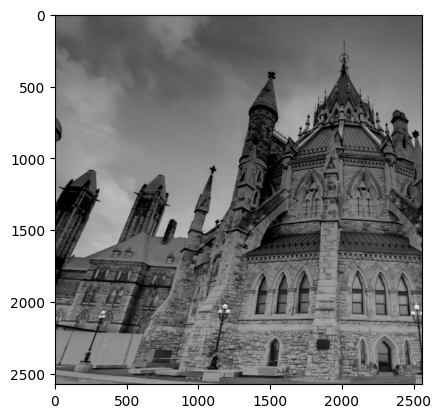

In [4]:
# 1. Convert images to grayscale
parliament_left = cv.imread("parliament-left.jpg")
parliament_right = cv.imread("parliament-right.jpg")

p_left = cv.cvtColor(parliament_left, cv.COLOR_BGR2GRAY)
p_right = cv.cvtColor(parliament_right, cv.COLOR_BGR2GRAY)

parliament_left = cv.cvtColor(parliament_left, cv.COLOR_BGR2RGB)
parliament_right = cv.cvtColor(parliament_right, cv.COLOR_BGR2RGB)

print(parliament_left.shape, parliament_left.dtype, p_left.shape)
plt.imshow(p_left, cmap='gray')

In [5]:
# 2. Detect SIFT keypoints and extract descriptors
sift= cv.SIFT_create()
lkp, ldes = sift.detectAndCompute(p_left, None)
rkp, rdes = sift.detectAndCompute(p_right, None)
print(len(lkp))
print(len(rkp))

16538
17642


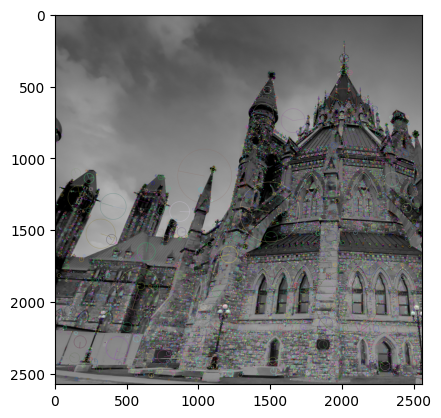

In [6]:
left_kp_overlay = cv.drawKeypoints(p_left, lkp, None, flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plt.imshow(left_kp_overlay)

In [7]:
# 3. Match features between left and right image
dist, matches = kn.feature.match_snn(torch.tensor(ldes), torch.tensor(rdes))
print(f"Total matches {dist.shape[0]}")

Total matches 8393


In [8]:
# 4. Prune features for top 10% of least descriptor distance
dist_sorti = dist.argsort(dim=0).squeeze()
top = dist_sorti[:int(len(dist_sorti) * 0.10)]
matches_new = matches[top,]

left_kp = torch.tensor([kp.pt for kp in lkp])
right_kp = torch.tensor([kp.pt for kp in rkp])

src_pts = left_kp[matches_new[:, 0]]
des_pts = right_kp[matches_new[:, 1]]

print(f"Sample pool of {src_pts.shape[0]} point pairs")

Sample pool of 839 point pairs


Assume 50.00% are outliers
Total RANSAC iterations: 34
Mapping radius threshold: 0.5 pixel
Actual RANSAC iterations: 34
RANSAC found 836 inliers from samples 839


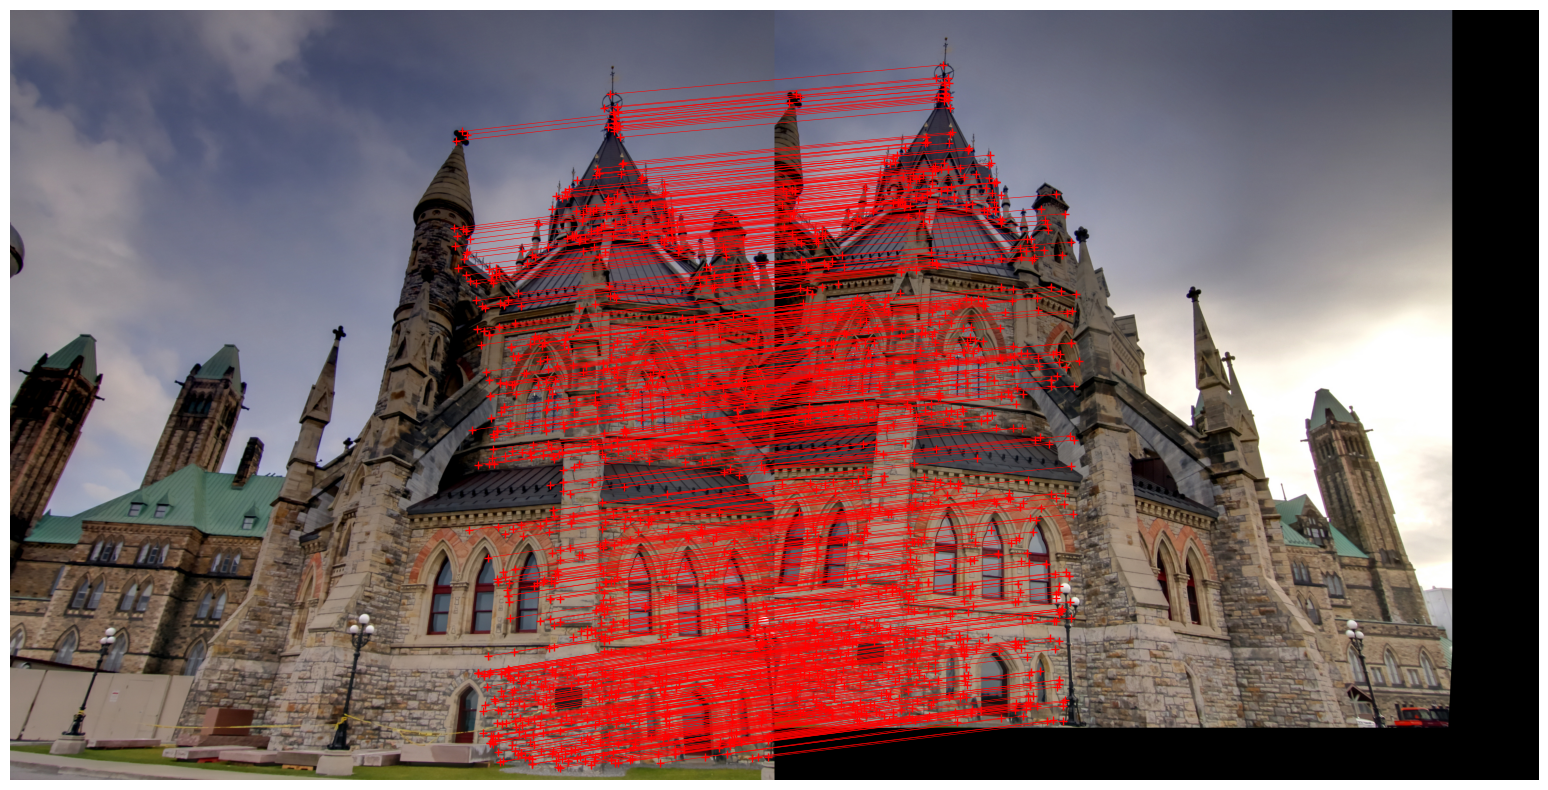

In [9]:
# 5. RANSAC estimate affine transformation
# Affine transformation has 6 degrees of freedom, thus needs at least 3 pairs of points to calculate

pool_N = src_pts.shape[0]
# p: desired probability of 1 good sample
# s: number of points (pair) in a sample, 3
# e: proportion of outliers, estimate 0.4-0.6
p = 0.99
s = 3
e = 0.5
print(f"Assume {e:.2%} are outliers")
# N: RANSAC iterations
N = int(log(1-p) / log(1-(1-e)**s))
print(f"Total RANSAC iterations: {N}")

# threshold: float, destination's pixel radius of acceptable mapping
threshold = 0.5
th2 = threshold ** 2
print(f"Mapping radius threshold: {threshold} pixel")
n = N
inliers, inliers_des = None, None
max_n, inlier_n = 0, 0

while n > 0 and max_n < pool_N:
    # random choose 3 point pairs from source and destination, find affine matrix
    choices = np.random.choice(pool_N, (3,), replace=False)
    affine = get_affine(src_pts[choices], des_pts[choices])
    # transform all source points towards destination, check distance threshold
    src_homo = torch.cat((src_pts, torch.ones(pool_N,1)), dim=-1)
    diff = src_homo @ affine - des_pts
    distance = torch.sum(torch.square(diff), dim=1)
    inlier_bool = distance < th2
    inlier_n = torch.sum(inlier_bool).item()
    if inlier_n > max_n:
        max_n = inlier_n
        inliers = src_pts[inlier_bool]
        inliers_des = des_pts[inlier_bool]
    n -= 1

print(f"Actual RANSAC iterations: {N-n}")
print(f"RANSAC found {max_n} inliers from samples {pool_N}")

# plot inliers match 
fig, ax = plt.subplots(figsize=(20,10))
l1, l2 = p_left.shape
r1, r2 = p_right.shape
h, w = max(l1, r1), max(l2, r2)

p_aug_left = np.zeros((h, w, 3), dtype=np.uint8)
p_aug_left[:l1, :l2, :] = parliament_left
p_aug_right = np.zeros((h, w, 3), dtype=np.uint8)
p_aug_right[:r1, :r2, :] = parliament_right
inliers_cat = torch.cat((inliers, inliers_des), dim=1).numpy()

plot_inlier_matches(ax, p_aug_left, p_aug_right, inliers_cat)

In [10]:
# 6. Optimal transformation using all inliers
aff = get_affine_all(inliers, inliers_des).unsqueeze(0)
print("Optimal affine transformation from inliers is:")
print(aff)

Optimal affine transformation from inliers is:
tensor([[[ 9.7834e-01, -5.1266e-02, -1.3876e+03],
         [ 5.1268e-02,  9.7825e-01, -1.9486e+02]]])


torch.Size([1, 3, 2575, 2556]) torch.Size([1, 3, 2575, 2556])
tensor([[[ 9.7834e-01, -5.1266e-02,  1.3103e+02],
         [ 5.1268e-02,  9.7825e-01,  0.0000e+00]]])


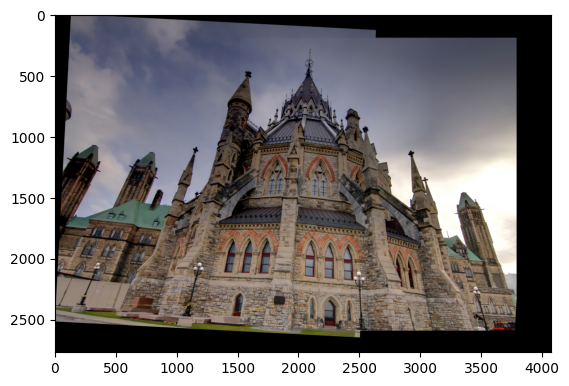

In [11]:
# 7. Create Panorama
# p_aug_left and p_aug_right now have the same dimension h*w
pt_left = kn.utils.image_to_tensor(p_aug_left, keepdim=False).float() / 255.
pt_right = kn.utils.image_to_tensor(p_aug_right, keepdim=False).float() / 255.
print(pt_left.shape, pt_right.shape)

# find the missing corner coordinates of source image when transforming
af = aff.squeeze().T
corner = torch.tensor([[0, 0, 1], [l1, 0, 1], [l1, l2, 1], [0, l2, 1]]).float()
corner_map = corner @ af
minx, miny = torch.min(corner_map, dim=0)[0]
minx, miny = abs(minx.item()), abs(miny.item())
# tune affine matrix translation to show the whole source image
aff_t = aff.detach().clone()
aff_t[..., 0, -1] += minx
aff_t[..., 1, -1] += miny
print(aff_t)
x, y = int(minx), int(miny)

l_pad = kn.geometry.transform.warp_affine(pt_left, aff_t, (h+y, w+x))
r_pad = torch.zeros(1, 3, h+y, w+x)
r_pad[..., y:, x:] = pt_right
blend = torch.max(l_pad, r_pad)
plt.imshow(kn.utils.tensor_to_image(blend))